In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import KFold

from sklearn.preprocessing import StandardScaler

In [2]:
team = pd.read_excel('team_data_model.xlsx')

In [3]:
# Storing Team Name in different dataframe to map it to the prediction later. 
team_name=team['Team_name']

# dropping some columns which doesn't look required for analysis
cols_to_drop=['venue','Team_name','Team_short_name','Year','Month','start_time','Team_id','winning_score',
             'loosing_score', 'Team_Points_all_out', 'Team_Points_extras',
       'Team_Points_declare', 'Team_Raid_Points_total',
       'Team_Raid_Points_touch', 'Team_Raid_Points_raid_bonus',
       'Team_Tackle_Points_total', 'Team_Tackle_Points_capture',
       'Team_Tackle_Points_capture_bonus']

team=team.drop(cols_to_drop, axis=1)

# Converting season column to category 
team['Season']=team['Season'].astype('category')

team.shape

(1272, 15)

### Model

In [4]:
# Creating train and test. We will test the model on Season 7 data

train=team[team['Season']!='Season 7']

test=team[team['Season']=='Season 7']

# Dropping Season column as it is no more required. The test and train data has been split basis the season
y_train=train['Team_Points_total']
train=train.drop(['Season','Team_Points_total'], axis=1)


y_test=test['Team_Points_total']
test=test.drop(['Season','Team_Points_total'], axis=1)

print("Train Data Shape is: ", train.shape)
print("Test Data Shape is: ", test.shape)

Train Data Shape is:  (1040, 13)
Test Data Shape is:  (232, 13)


In [5]:
print('Train Shape is', train.shape)
print('y_train Shape is', y_train.shape)

Train Shape is (1040, 13)
y_train Shape is (1040,)


In [6]:
print('Test Shape is', test.shape)
print('y_test Shape is', y_test.shape)

Test Shape is (232, 13)
y_test Shape is (232,)


In [7]:
# Scaling the features
# storing the columns in a variable for avoiding them from lossing after scaling
X_train_cols=train.columns

scaler=StandardScaler()
train[X_train_cols]=scaler.fit_transform(train[X_train_cols])

train.head()

,home_team_name,Team_Raids_total,Team_Raids_successful,Team_Raids_unsuccessful,Team_Raids_Empty,Team_Tackles_total,Team_Tackles_successful,Team_Tackles_unsuccessful,winning_team,toss_winner,toss_choice,toss_direction,winning_margin
0,-0.503003,-0.587692,1.247651,0.167896,-1.793128,0.251199,-2.456764,1.791561,-0.899275,-1.0,0.0,0.0,-1.336730
1,1.988060,-0.587692,1.473785,-1.716403,-0.760312,1.954522,0.424854,1.589191,1.112007,1.0,0.0,0.0,1.336730
2,-0.503003,-0.587692,0.795383,0.481946,-1.793128,-0.387547,1.385393,-1.243994,1.112007,-1.0,0.0,0.0,1.814134
3,-0.503003,-0.365760,-0.109153,2.366244,-1.793128,2.167437,0.745034,1.589191,-0.899275,1.0,0.0,0.0,-1.814134
4,-0.503003,-0.365760,-0.109153,0.795995,-0.760312,0.677030,1.385393,-0.232142,1.112007,1.0,0.0,0.0,0.286442


In [8]:
# Scaling the test data
test[X_train_cols]=scaler.transform(test[X_train_cols])
test.head()

,home_team_name,Team_Raids_total,Team_Raids_successful,Team_Raids_unsuccessful,Team_Raids_Empty,Team_Tackles_total,Team_Tackles_successful,Team_Tackles_unsuccessful,winning_team,toss_winner,toss_choice,toss_direction,winning_margin
1028,-0.503003,0.300034,0.343115,-0.146154,0.065941,0.038284,0.424854,-0.232142,1.112007,-1.0,0.0,0.0,0.668365
1029,-0.503003,0.300034,0.116981,0.795995,-0.347185,0.464114,-0.215506,0.577339,-0.899275,1.0,0.0,0.0,-0.668365
1030,-0.503003,0.300034,1.926053,-0.146154,-1.380002,0.251199,-0.535685,0.577339,1.112007,1.0,0.0,0.0,0.477404
1031,-0.503003,0.300034,1.021517,-0.774253,-0.140622,1.528691,-0.215506,1.589191,-0.899275,-1.0,0.0,0.0,-0.477404
1044,1.988060,-0.587692,-0.109153,0.481946,-0.760312,0.251199,0.104674,0.172599,-0.899275,-1.0,0.0,0.0,-0.572884


In [9]:
# Defining alphas for identiying the optimum alphas for Lasso regression
params = {'alpha': [0.00000000001, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001,0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5,
                    0.6,0.7,0.8,0.9]}

# Lasso Modelling
lasso = Lasso()

# cross validation
folds=5
lasso_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

lasso_cv.fit(train, y_train) 

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  95 out of  95 | elapsed:    0.3s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [1e-11, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001,
                                   0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4,
                                   0.5, 0.6, 0.7, 0.8, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [10]:
# Printing the model output

lasso_cv_results = pd.DataFrame(lasso_cv.cv_results_)
lasso_cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.014096,0.013358,0.000991,6.311754e-04,1e-11,{'alpha': 1e-11},-2.358631,-1.798371,-1.779835,-1.984878,...,-1.986271,0.208386,9,-1.859637,-1.938173,-1.948401,-1.897041,-1.883813,-1.905413,0.033326
1,0.005186,0.001453,0.000998,4.370285e-07,1e-08,{'alpha': 1e-08},-2.358631,-1.798371,-1.779835,-1.984878,...,-1.986271,0.208385,8,-1.859637,-1.938173,-1.948401,-1.897041,-1.883813,-1.905413,0.033326
2,0.005386,0.000797,0.000798,3.988039e-04,1e-07,{'alpha': 1e-07},-2.358631,-1.798371,-1.779835,-1.984878,...,-1.986271,0.208385,7,-1.859637,-1.938173,-1.948401,-1.897041,-1.883813,-1.905413,0.033326
3,0.004781,0.001163,0.000998,1.766397e-05,1e-06,{'alpha': 1e-06},-2.358627,-1.798370,-1.779834,-1.984880,...,-1.986271,0.208384,6,-1.859637,-1.938174,-1.948403,-1.897042,-1.883815,-1.905414,0.033327
4,0.004981,0.000629,0.000599,4.891229e-04,1e-05,{'alpha': 1e-05},-2.358595,-1.798368,-1.779832,-1.984897,...,-1.986269,0.208374,5,-1.859637,-1.938188,-1.948415,-1.897056,-1.883830,-1.905425,0.033330


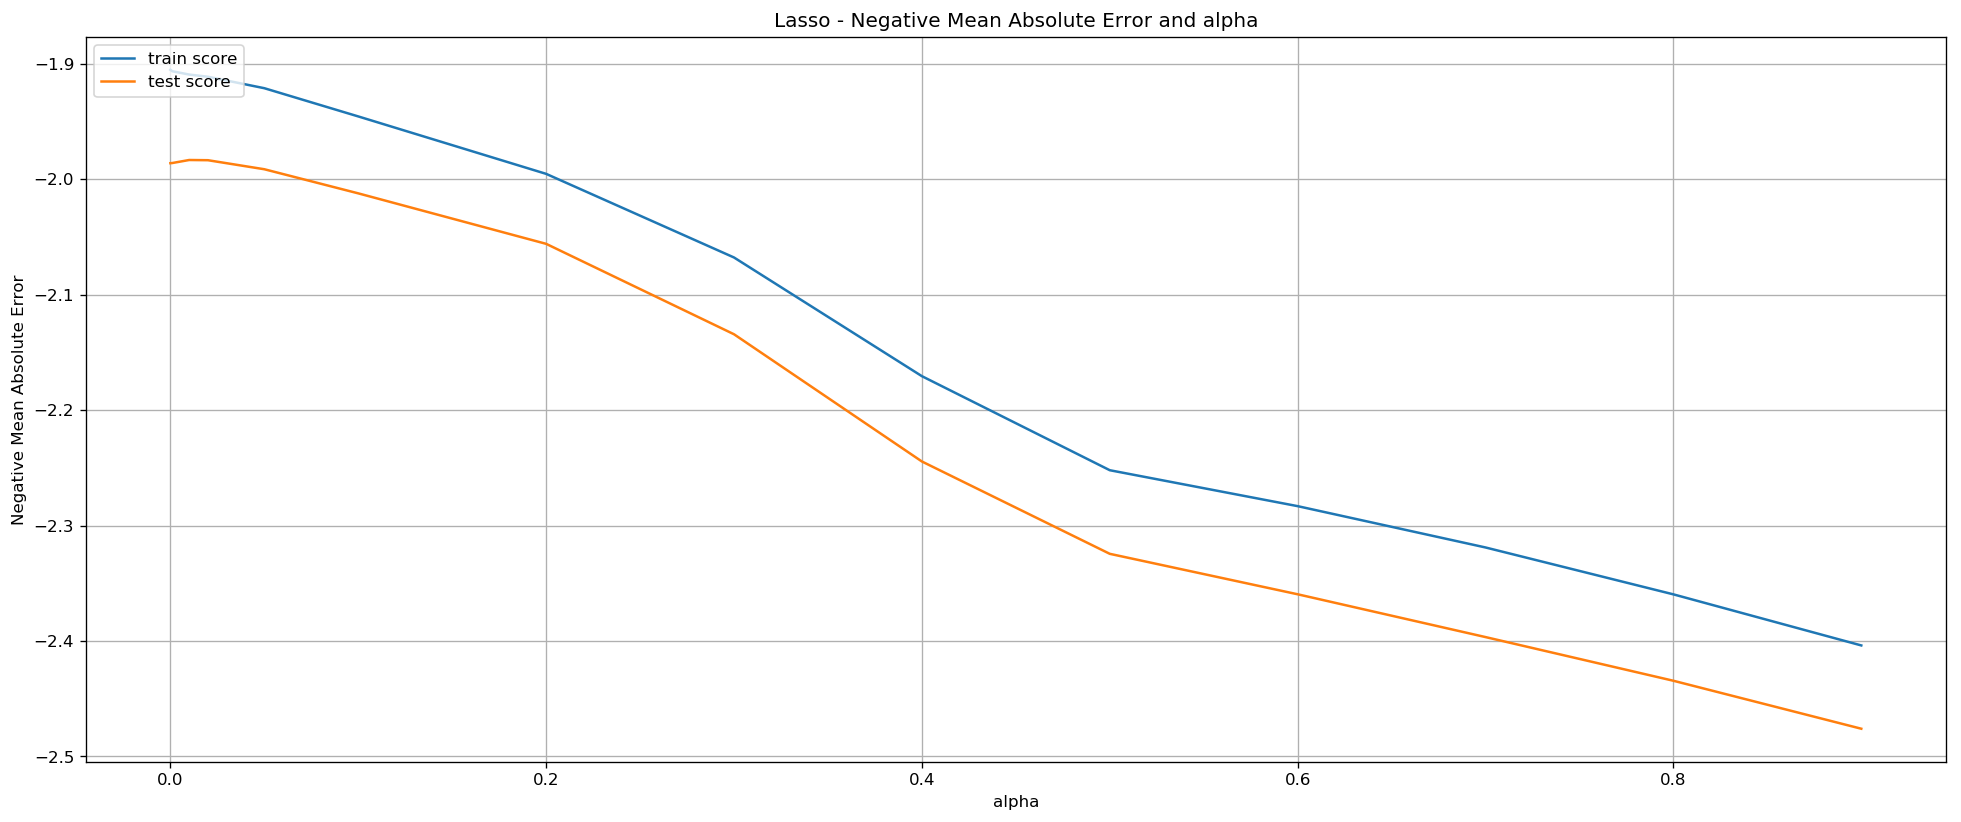

In [11]:
# plotting mean test and train scoes with alpha 
lasso_cv_results['param_alpha'] = lasso_cv_results['param_alpha'].astype('float32')

# plotting
plt.figure(num=None, figsize=(20, 8), dpi=120, facecolor='w', edgecolor='k')
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_train_score'])
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Lasso - Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.grid()
plt.show()

In [12]:
print(lasso_cv.best_params_['alpha'])

0.01


In [13]:
alpha = lasso_cv.best_params_['alpha']
lasso = Lasso(alpha=alpha)
lasso.fit(train, y_train) 

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [14]:
lasso.score(train, y_train)

0.9023071112429806

In [15]:
lasso.score(test, y_test)

0.9021513761050446

In [16]:
y_test_pred=lasso.predict(test)
print(r2_score(y_test,y_test_pred))
print(np.sqrt(mean_squared_error(y_test,y_test_pred)))

0.9021513761050446
2.3553959503369417


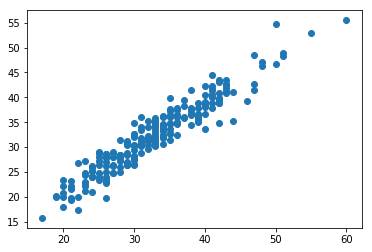

In [17]:
plt.scatter(y_test,y_test_pred)

In [18]:
features = np.abs(pd.Series(dict(zip(train.columns,lasso.coef_)))).sort_values(ascending=False)
print(features)

winning_margin               5.963464
Team_Raids_successful        3.085567
Team_Raids_unsuccessful      2.030780
Team_Tackles_total           2.030327
Team_Tackles_unsuccessful    0.924210
winning_team                 0.376280
home_team_name               0.022047
Team_Raids_total             0.014456
toss_winner                  0.009454
toss_direction               0.000000
toss_choice                  0.000000
Team_Tackles_successful      0.000000
Team_Raids_Empty             0.000000
dtype: float64


In [19]:
top_points_team = pd.DataFrame(np.array([team_name.loc[test.index].values,y_test]).T,columns=['Team','Total Points'])
top_points_team['Total Points'] = top_points_team['Total Points'].astype('int')
top_points_team = top_points_team[['Team','Total Points']].groupby('Team').sum().sort_values(by='Total Points',ascending=False)
top_points_team.head()

,Total Points
Team,
Dabang Delhi K.C.,709
Bengaluru Bulls,694
Bengal Warriors,676
Gujarat Fortunegiants,676
Puneri Paltan,652
